<a href="https://colab.research.google.com/github/NikiforosYO/hello-world/blob/master/AIMS_Intro_to_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download data
!gdown -q https://drive.google.com/uc?id=1-pRPliOdTp9lvc2lPwNsqeWDy82D5W02
!tar -xzf sample.tar.gz 

In [2]:
#@title How many images are there?
# Set seeds
import random, torch, os, numpy as np
def set_reproducibility(SEED):
  os.environ['PYTHONHASHSEED'] = f'{SEED}'
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  #print(f'Setting random seed to {SEED} !\n')
  torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
  torch.backends.cudnn.enabled   = True


set_reproducibility(42)


# Importing some libraries to get started ...
import albumentations as A
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os, os.path as osp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


df = pd.read_csv('sample/labels.csv').drop_duplicates().reset_index(drop=True)
print(f'There are {len(df)} chest X-rays !\n')
print(df['class'].value_counts())

There are 997 chest X-rays !

Normal                          500
No Lung Opacity / Not Normal    250
Lung Opacity                    247
Name: class, dtype: int64


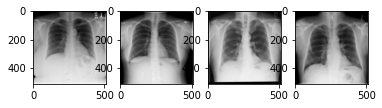

In [3]:
#@title What do they look like?
images = glob.glob('sample/images/*.jpg')
np.random.seed(88)
sample = np.random.choice(images, 4, replace=False)
for i in range(len(sample)):
  plt.subplot(1,len(sample),i+1)
  plt.imshow(cv2.imread(sample[i]), cmap='gray')
plt.show()

In [4]:
#@title Split the data into TRAIN, VALIDATION, TEST
np.random.seed(88)

train_proportion = 70 #@param {type:"slider", min:0, max:100, step:5}
valid_proportion = 10 #@param {type:"slider", min:0, max:100, step:5}
test_proportion = 20 #@param {type:"slider", min:0, max:100, step:5}

assert train_proportion+valid_proportion+test_proportion == 100, \
  'Train, validation, and test proportions must sum to 100 !'

train = np.random.choice(df.patientId.values, int(train_proportion/100*len(df)), 
                         replace=False)
not_train = list(set(df.patientId.values)-set(train))
valid = np.random.choice(not_train, int(valid_proportion/100*len(df)), 
                         replace=False)
test = list(set(not_train)-set(valid))

train_df = df[df.patientId.isin(train)]
valid_df = df[df.patientId.isin(valid)]
test_df  = df[df.patientId.isin(test)]

print(f'TRAIN: N={len(train_df)}')
print(f'VALID: N={len(valid_df)}')
print(f'TEST:  N={len(test_df)}\n')

print('TRAIN DISTRIBUTION')
print(train_df['class'].value_counts(normalize=True))
print('\nVALID DISTRIBUTION')
print(valid_df['class'].value_counts(normalize=True))
print('\nTEST DISTRIBUTION')
print(test_df['class'].value_counts(normalize=True))

TRAIN: N=697
VALID: N=99
TEST:  N=201

TRAIN DISTRIBUTION
Normal                          0.499283
Lung Opacity                    0.251076
No Lung Opacity / Not Normal    0.249641
Name: class, dtype: float64

VALID DISTRIBUTION
Normal                          0.555556
No Lung Opacity / Not Normal    0.242424
Lung Opacity                    0.202020
Name: class, dtype: float64

TEST DISTRIBUTION
Normal                          0.482587
Lung Opacity                    0.258706
No Lung Opacity / Not Normal    0.258706
Name: class, dtype: float64


In [6]:
#@title Basic training parameters
height = 256 #@param {type:"slider", min:128, max:512, step:32}  
width = 256 #@param {type:"slider", min:128, max:512, step:32}  
batch_size = 16 #@param {type:"slider", min:2, max:128, step:2}  
learning_rate = -4 #@param {type:"slider", min:-8, max:-1, step:1}
learning_rate = 10 ** learning_rate
num_epochs = 10 #@param {type:"slider", min:1, max:20, step:1}

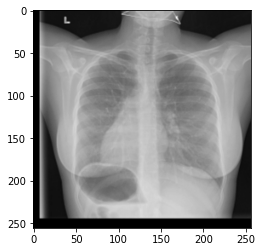

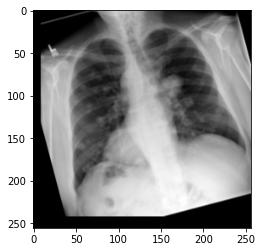

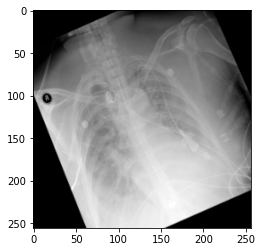

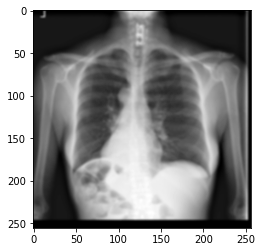

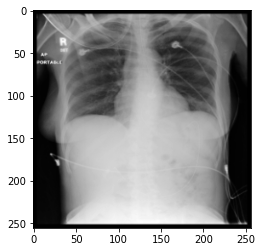

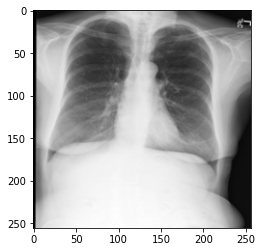

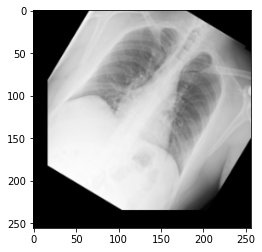

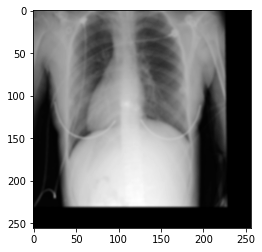

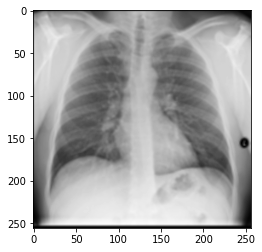

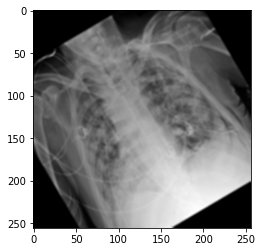

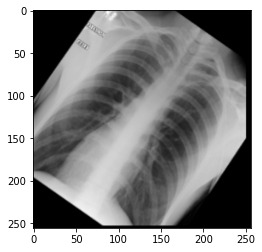

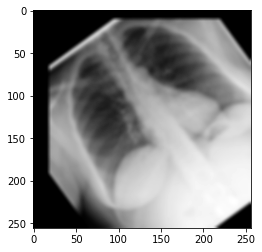

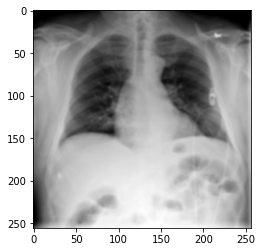

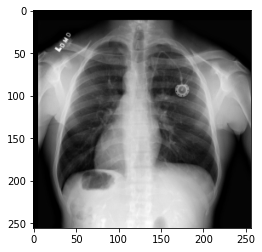

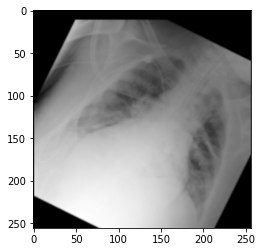

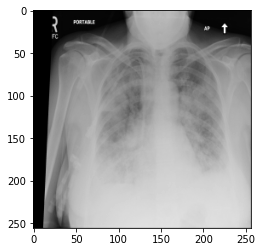

In [7]:
#@title Data augmentation

class CXRDataset(Dataset):

  def __init__(self,
               inputs,
               labels,
               imsize,
               augment):
    self.inputs = inputs
    self.labels = labels
    self.imsize = imsize
    self.augment = augment
  
  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, i):
    img = cv2.imread(self.inputs[i])
    img = cv2.resize(img, self.imsize)
    if self.augment:
      img = self.augment(image=img)['image']
    img = img.astype('float32')
    img /= 255.
    img -= 0.5
    img *= 2.0
    img = img.transpose(2,0,1)
    return torch.tensor(img).float(), torch.tensor(self.labels[i])


height = 256 #param {type:"slider", min:128, max:512, step:32}  
width = 256 #param {type:"slider", min:128, max:512, step:32}  
data_augmentation = True #@param {type:"boolean"}
proba = 1 #@param {type:"slider", min:0, max:1.0, step:0.05}
rotate = 40 #@param {type:"slider", min:0, max:45, step:5}
flip = True #@param {type:"boolean"}
scale = 10 #@param {type:"slider", min: 0, max:75, step:1}
shift = 10 #@param {type:"slider", min: 0, max:75, step:1}
blur = 5 #@param {type:"slider", min: 0, max: 50, step:1}

AUGMENTATIONS = [
  A.Rotate(rotate,
           border_mode=cv2.BORDER_CONSTANT), 
  A.ShiftScaleRotate(shift_limit=0, 
                     rotate_limit=0, 
                     scale_limit=(-scale/100,scale/100),
                     border_mode=cv2.BORDER_CONSTANT),
  A.ShiftScaleRotate(shift_limit=(-shift/100,shift/100), 
                     rotate_limit=0, 
                     scale_limit=0,
                     border_mode=cv2.BORDER_CONSTANT),
  A.Blur(blur)
]

if flip: AUGMENTATIONS += [A.HorizontalFlip()]

AUGMENTATIONS = A.Compose(A.OneOf(AUGMENTATIONS), p=proba)

label_dict = {
    'Normal': 0,
    'No Lung Opacity / Not Normal': 1,
    'Lung Opacity': 2
}

train_dataset = CXRDataset(inputs=[osp.join('sample', 'images', _+'.jpg') for _ in train_df.patientId],
                     labels=[label_dict[_] for _ in train_df['class']],
                     imsize=(height,width),
                     augment=AUGMENTATIONS if data_augmentation else None)

valid_dataset = CXRDataset(inputs=[osp.join('sample', 'images', _+'.jpg') for _ in valid_df.patientId],
                     labels=[label_dict[_] for _ in valid_df['class']],
                     imsize=(height,width),
                     augment=None)

test_dataset = CXRDataset(inputs=[osp.join('sample', 'images', _+'.jpg') for _ in test_df.patientId],
                     labels=[label_dict[_] for _ in test_df['class']],
                     imsize=(height,width),
                     augment=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

for data in train_loader:
  break

data = data[0].cpu().numpy().transpose(0,2,3,1)
for i, d in enumerate(data):
  d += 1
  d *= 0.5
  d *= 255. 
  d = d.astype('uint8')
  plt.imshow(d[...,0], cmap='gray')
  plt.show()

In [8]:
#@title Let's start training !

imagenet_pretrained = True #@param {type:"boolean"}
print('Building ResNet50 classifier ...\n')
model = resnet50(pretrained=imagenet_pretrained)
model.fc.out_features = 3
model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=1.0e-4)
criterion = nn.CrossEntropyLoss()
model.train()

best_auc = 0
losses, acclist, auclist = [], [], []
print('TRAINING : START')
for epoch in range(num_epochs):
  pbar = tqdm(train_loader, desc=f'EPOCH {epoch:02d}')
  for data in pbar:
    images, labels = data
    optimizer.zero_grad()
    output = model(images.cuda())
    loss = criterion(output, labels.cuda())
    loss.backward()
    optimizer.step()
    losses += [loss.item()]
    pbar.set_postfix({'loss': f'{np.mean(losses[-min(len(losses),10):]):.4f}'})
  print('VALIDATING ...')
  pbar = tqdm(valid_loader)
  predictions = []
  groundtruth = []
  model.eval()
  for data in pbar:
    images, labels = data
    with torch.no_grad():
      output = model(images.cuda())
    predictions += [output.cpu().numpy()]
    groundtruth += [labels.cpu().numpy()]
  predictions = np.concatenate(predictions)
  groundtruth = np.concatenate(groundtruth)
  valid_acc = np.mean(np.argmax(predictions, axis=1)==groundtruth)*100
  valid_auc = roc_auc_score((groundtruth!=0).astype("float"), -predictions[:,0])
  acclist += [valid_acc]
  auclist += [valid_auc]
  if valid_auc > best_auc:
    best_model = copy.deepcopy(model)
    best_auc = valid_auc
  print(f'ACC: {valid_acc:.2f}%')
  print(f'AUC: {valid_auc:.4f}')
  model.train()

print(f'\nHighest AUC {best_auc:.4f} occurred at epoch {np.argmax(auclist):02d}')  

Building ResNet50 classifier ...



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



TRAINING : START



VALIDATING ...



ACC: 69.70%
AUC: 0.8645



VALIDATING ...



ACC: 67.68%
AUC: 0.8665



VALIDATING ...



ACC: 59.60%
AUC: 0.8682



VALIDATING ...



ACC: 72.73%
AUC: 0.9062



VALIDATING ...



ACC: 69.70%
AUC: 0.9050



VALIDATING ...



ACC: 66.67%
AUC: 0.8930



VALIDATING ...



ACC: 75.76%
AUC: 0.8988



VALIDATING ...



ACC: 67.68%
AUC: 0.9087



VALIDATING ...



ACC: 73.74%
AUC: 0.8860



VALIDATING ...



ACC: 68.69%
AUC: 0.8992

Highest AUC 0.9087 occurred at epoch 07


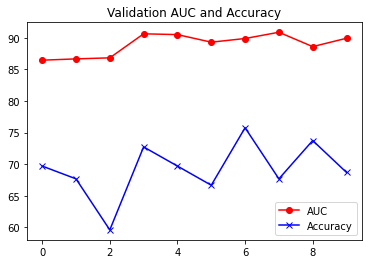

In [9]:
#@title Plot validation results

ax = plt.subplot(1,1,1)
plt.title('Validation AUC and Accuracy')
line1 = ax.plot(np.arange(len(auclist)), np.asarray(auclist)*100, 'o-', color='red', label='AUC')
line2 = ax.plot(np.arange(len(acclist)), acclist, 'x-', color='blue', label='Accuracy')
leg = ax.legend()

In [10]:
#@title Run model on test data
print('TESTING ...\n')
pbar = tqdm(test_loader)
predictions = []
groundtruth = []
best_model.eval()
for data in pbar:
  images, labels = data
  with torch.no_grad():
    output = best_model(images.cuda())
  predictions += [output.cpu().numpy()]
  groundtruth += [labels.cpu().numpy()]
predictions = np.concatenate(predictions)
groundtruth = np.concatenate(groundtruth)
test_acc = np.mean(np.argmax(predictions, axis=1)==groundtruth)*100
test_auc = roc_auc_score((groundtruth!=0).astype("float"), -predictions[:,0])

print(f'TEST ACC : {test_acc:.2f}%')
print(f'TEST AUC : {test_auc:.4f}')

TESTING ...




TEST ACC : 66.17%
TEST AUC : 0.8897
